In [1]:
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
!pip install -q torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html


     |████████████████████████████████| 11.9MB 7.3MB/s 
     |████████████████████████████████| 24.3MB 131kB/s 
     |████████████████████████████████| 235kB 3.4MB/s 
     |████████████████████████████████| 2.2MB 10.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 21.5MB 110.6MB/s 
     |████████████████████████████████| 6.4MB 4.7MB/s 


In [2]:

import os.path as osp
import argparse

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv,GATConv  # noqa

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling
from torch_geometric.data import NeighborSampler

dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]
train_loader = NeighborSampler(data.edge_index, batch_size = 1078, node_idx=data.train_mask, sizes=[25, 10],
                               shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)
subgraph_loader=NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],batch_size=2708, shuffle=False,num_workers=12)
    
from torch.optim.lr_scheduler import ReduceLROnPlateau


Processing...
Done!


In [55]:
class Net(torch.nn.Module):
    def __init__(self,mode='UNSUP',conv='GCN'):
        super(Net, self).__init__()
        self.mode = mode
        self.conv=conv
        self.num_layers = 2
        
        self.convs = torch.nn.ModuleList()
    
        if self.mode=='UNSUP':
            out_channels = 128
        elif self.mode=='SUP':
            out_channels = dataset.num_classes
        
        if self.conv == 'GCN':
            self.convs.append(GCNConv(dataset.num_features, 260))
            self.convs.append(GCNConv(260, out_channels))
        if self.conv == 'SAGE':
            self.convs.append(SAGEConv(dataset.num_features, 260))
            self.convs.append(SAGEConv(260, out_channels))
        if self.conv == 'GAT':
            self.convs.append(GATConv(dataset.num_features, 260))
            self.convs.append(GATConv(260, out_channels))
                
    def forward(self,x,adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        if self.mode=='UNSUP':
            return x
        elif self.mode=='SUP':
            return x.log_softmax(dim=-1)
    def inference(self,x):    
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = x.to(device)
        edge_idex = edge_index.to(device)
        x = F.relu(self.convs[0](x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.convs[1](x, edge_index, edge_weight)
        if self.mode=='UNSUP':
            return x
        elif self.mode=='SUP':
            return x.log_softmax(dim=-1)
              
    def loss_RW_SAGE(self,out, pos_rw,neg_rw):
        # Positive loss.
        pos_loss=0
        length = 0 
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()
        h_start = out[start].view(pos_rw.size(0), 1,128)
        h_rest = out[rest.view(-1)].view(pos_rw.size(0), -1,128)
        dot = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(dot)).mean()
        
        # Negative loss.
        neg_loss=0
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()

        h_start =out[start].view(neg_rw.size(0), 1,128)
        h_rest =  out[rest.view(-1)].view(neg_rw.size(0), -1,128)

        dot = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(torch.sigmoid((-1)*dot)).mean()

        return pos_loss + neg_loss
    
    ##loss function for supervised     
    def loss_sup(self, pred, label):
        return F.nll_loss(pred, label)


In [56]:
#Сэмплирование позитивных и негативных примеров  
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor

row=[]
col =[]
x_new = [j for j in range(len(x))]
x_new = torch.IntTensor(x_new)
x_new = x_new[data.train_mask]
for j, i in enumerate(data.edge_index[0]):
    if i in x_new:
        if data.edge_index[1][j] in x_new:
                row.append(i)
                col.append(data.edge_index[1][j])


row = torch.tensor(row)
row = row.to(device)
col = torch.tensor(col)
col = col.to(device)

adj = SparseTensor(row=row, col=col, sparse_sizes=(140, 140)).to(device)

from torch_cluster import random_walk
def pos_sample(batch):
        p=1
        q=1
        walk_length = 20
        walks_per_node = 10
        context_size = 10
        batch = batch.repeat(walks_per_node)
        rowptr, col, _ = adj.csr()
        rowptr = rowptr.to(device)
        col = col.to(device)
        rw = random_walk(row, col, batch,  walk_length, p, q)
        walks = []
        num_walks_per_rw = 1 + walk_length + 1 - context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + context_size])
        return torch.cat(walks, dim=0)
def neg_sample(batch):
    walks_per_node = 10
    num_negative_samples = 1
    walk_length = 20 
    context_size = 10
    batch = batch.repeat(walks_per_node * num_negative_samples)

    rw = torch.randint(adj.sparse_size(0), (batch.size(0), walk_length)).to(device)
    rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

    walks = []
    num_walks_per_rw = 1 + walk_length + 1 - context_size
    for j in range(num_walks_per_rw):
        walks.append(rw[:, j:j + context_size])
    return torch.cat(walks, dim=0)
def sample(batch):
    if not isinstance(batch, torch.Tensor):
        batch = torch.tensor(batch).to(device)
    return pos_sample(batch),neg_sample(batch)

loader = DataLoader(range(adj.sparse_size(0)),collate_fn=sample)

In [57]:
#UNSUPERVISED
model = Net(mode='UNSUP',conv='GAT')
#model.type(torch.cuda.FloatTensor)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min') 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 


def train(epoch):
    model.train()
    total_loss = 0
    for _, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        out = model.forward(x[n_id].to(device), adjs)
        optimizer.zero_grad()
        for i, (pos_rw, neg_rw) in enumerate(loader):
           loss = model.loss_RW_SAGE(out, pos_rw.to(device), neg_rw.to(device))
           total_loss+=loss
    total_loss.backward(retain_graph=True)
    optimizer.step()      
    return total_loss /len(loader)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
@torch.no_grad()
def test():
    model.eval()
    out = model.inference(x.to(device)).to(device)
    y_true = y.cpu().detach().numpy()
    clf = MLPClassifier(random_state=1, max_iter=2000).fit(out.cpu().detach().numpy(),y_true)
    y_pred = clf.predict(out.cpu().detach().numpy())
    #cm = confusion_matrix(y_true,y_pred)
    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        print((clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy())))
        results += [(clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy()))]
        
    return results

In [58]:
import time
losses=[]
train_accs =[]
val_accs =[]
test_accs=[]
k = time.clock() 
for epoch in range(1, 10):
    loss = train(epoch)
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    #train_accs.append(train_acc)
    #test_accs.append(test_acc)
    #val_accs.append(val_acc)
    scheduler.step(loss)
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(loss)
    #print(log.format(loss, epoch, train_acc, val_acc, test_acc))
print(time.clock() - k) 

RuntimeError: ignored

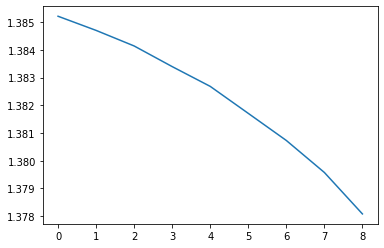

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

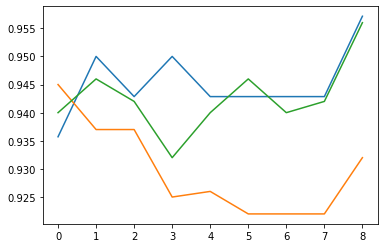

In [ ]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.plot(val_accs)